In [1]:
# %load PostProcessing/loadResults.py
import itertools
import pickle
import os
import numpy as np
from utils import *
from math import sqrt
import matplotlib.pyplot as plt


def load_history(projPath, filename="history.json"): #{{{
    '''
    load history data
    '''
    modelPath = projPath + "/" + filename
    with open(modelPath,  'rb') as f:
        data = pickle.load(f)
    return data#}}}
def load_history_at_weights(weights, projPath="./Models/", prefix="SSA1D_weights", filename="history.json"): #{{{
    '''
    load all history data with given weights 
    '''
    # get all the folders in the projPath
    foldersList = os.listdir(projPath)

    # get filename pattern
    filename_pattern = prefix + "".join([str(w)+"_" for w in weights])

    # filter
    filteredList = [f for f in foldersList if filename_pattern in f]

    return [load_history(projPath+f) for f in filteredList] #}}}
def get_final_errors(data): #{{{
    keys = data.keys()
    return {k:data[k][-1] for k in keys}
    #}}}
def upscale_by_weights(dataDict, keys, weights): #{{{
    for k,w in zip(keys,weights):
        dataDict[k] = (dataDict[k]/w) if k in dataDict else dataDict[k]
    return dataDict
    #}}}

if __name__ == "__main__":
    # load C true solution
    path = os.path.join("./matlab_SSA/DATA/Helheim_Weertman_iT080_PINN_flowline_CF_2dInv.mat")
    x, Exact_vel, X_star, u_star, X_u_train, u_train, X_f, X_bc, u_bc, X_cf, n_cf, xub, xlb, uub, ulb, mu = prep_Helheim_data_flowline(path, 50, 100) 
    C_true = u_star[:,3:4]
    Cnorm = np.linalg.norm(C_true, 2)
    NC = len(C_true)
    

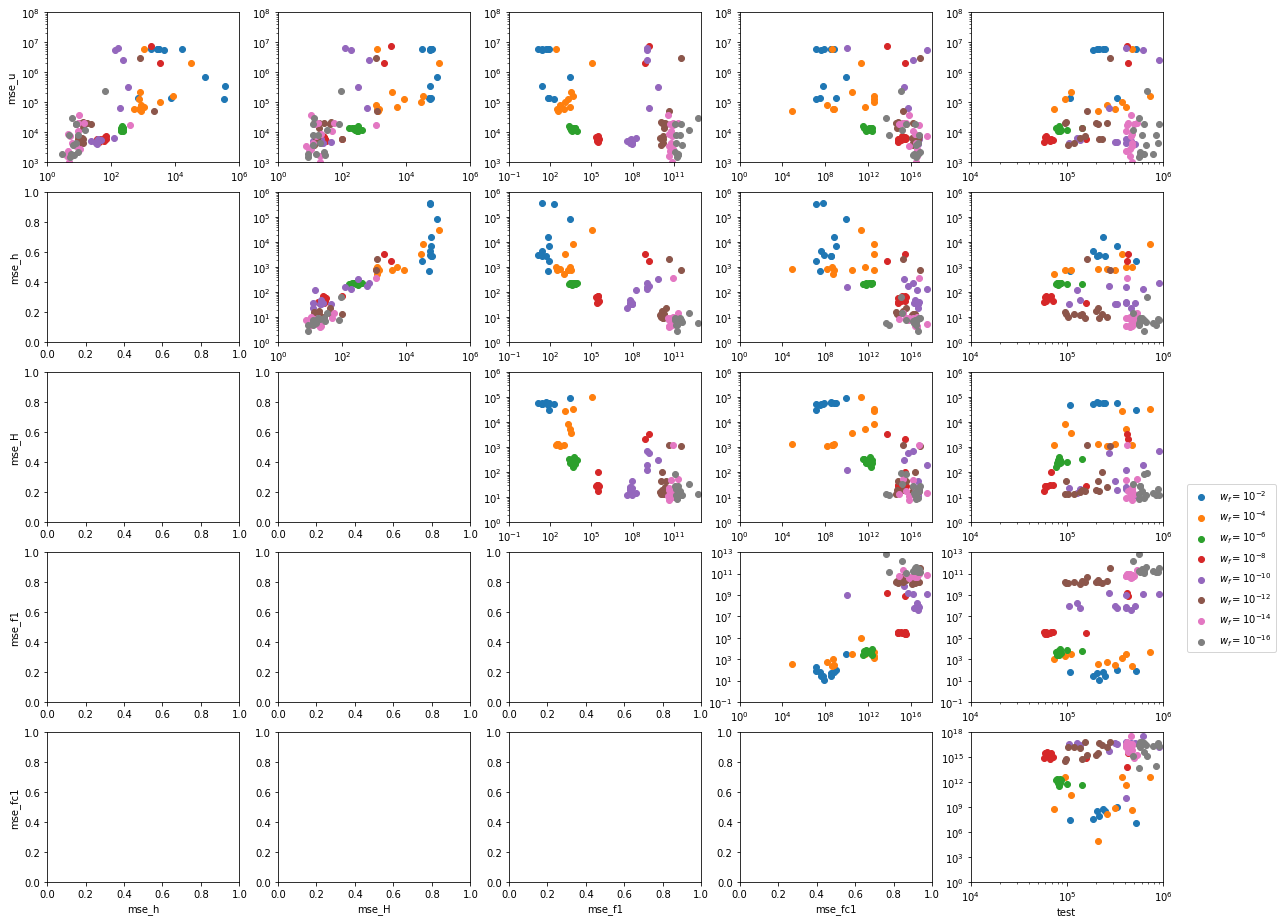

In [5]:
    # weights: u, h/H, C, f1, fc1 
    wu = [5]
    wh = [3]
    wC = [5]
    wf1 = list(range(2,18,2))  # 10
 
    weightsList = [(wu[0],wh[0],wC[0], w, w+10) for w in wf1] 
    
    # initialization
    dataList = []
    errorDict = {}

    # create the (key,weights) pair
    keys = ['mse_u', 'mse_h', 'mse_H', 'mse_f1', 'mse_fc1', 'test']
    wids = [0, 1, 1, 3, 4]
    
    # loop through experiments 
    for weights in weightsList:
        # load all history data
        dataList = load_history_at_weights(weights, prefix="SSA1D_3NN_8x20_noise_0.01_0_0_0_weights")
        # compute the weights
        loss_weights = [10**(-weights[i]) for i in wids]        
        # get the error in the final epoch
        final_epoch = [upscale_by_weights(get_final_errors(data), keys, loss_weights) for data in dataList]
        
        # adjuest the test resutls
        for e in final_epoch:
            e['test'] = (e['test']*Cnorm)**2/NC
#             e['test'] = e['test']
        # save data
        errorDict[weights] = {key: [i[key] for i in final_epoch] for key in final_epoch[0]}

    # plot
    fig, axs = plt.subplots(5, 5, figsize=(20,16))
    
    # colors indicates different weights combinations
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # PIN
    features = ['mse_u', 'mse_h', 'mse_H', 'mse_f1', 'mse_fc1', 'test']
    lims = [[1e3, 1e8], [1e0, 1e6], [1e0, 1e6], [1e-1, 1e13], [1,1e18], [1e4,1e6]]
    
    for cid, weights in enumerate(weightsList):
        err=errorDict[weights]
        label = '$w_f=10^{-'+str(weights[3])+'}$'

        for i in range(len(features)-1):
            for j in range(i,len(features)-1):
                ax = axs[i][j]
                ax.scatter(err[features[j+1]], err[features[i]], c=colors[cid], label=label)    
                ax.set_xscale('log')
                ax.set_xlim(lims[j+1])
                ax.set_yscale('log')
                ax.set_ylim(lims[i])
                
        # add labels
        for i in range(len(features)-1):
            ax = axs[i][0]
            ax.set_ylabel(features[i])
        for j in range(len(features)-1):
            ax = axs[-1][j]
            ax.set_xlabel(features[j+1])   
            
    ax.legend(bbox_to_anchor=(1.1, 1.5))